In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import gdown

# Predicting Student Admissions with Neural Networks
In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

### Load and visualize raw data

In [4]:
!gdown 1s-GLmnqjvkBrSPYpcT716dBBgyXiquGW

Downloading...
From: https://drive.google.com/uc?id=1s-GLmnqjvkBrSPYpcT716dBBgyXiquGW
To: C:\Users\Asus\student_data.csv

  0%|          | 0.00/5.09k [00:00<?, ?B/s]
100%|##########| 5.09k/5.09k [00:00<?, ?B/s]


In [2]:
data = pd.read_csv('student_data.csv')
print('data shape: ', data.shape)
data.head(5)

data shape:  (400, 4)


,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [5]:
def plot_points(data):
    X = np.array(data[['gre', 'gpa']])
    y = np.array(data['admit'])
    admitted = X[np.argwhere(y == 1)]
    rejected = X[np.argwhere(y == 0)]
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'yellow', edgecolor = 'k')
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.xlabel('GRE Test Score')
    plt.ylabel('GPA Score')
    plt.legend(['admitted', 'rejected'])

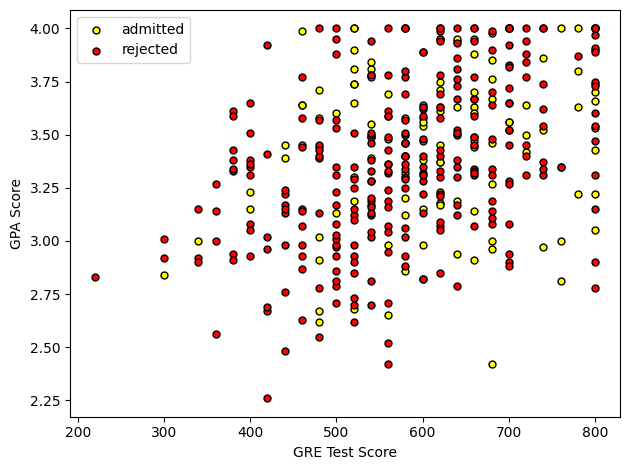

In [6]:
plot_points(data)
plt.tight_layout()
plt.show()

Roughly, it looks like the students with high GPA scores and GRE scores are highly likely to get admission, while the ones with low scores didn't. However, the data is not as nicely separable as we hoped it would. Maybe it would help to take the rank into account.

In [7]:
data_rank1 = data[data['rank'] == 1]
data_rank2 = data[data['rank'] == 2]
data_rank3 = data[data['rank'] == 3]
data_rank4 = data[data['rank'] == 4]

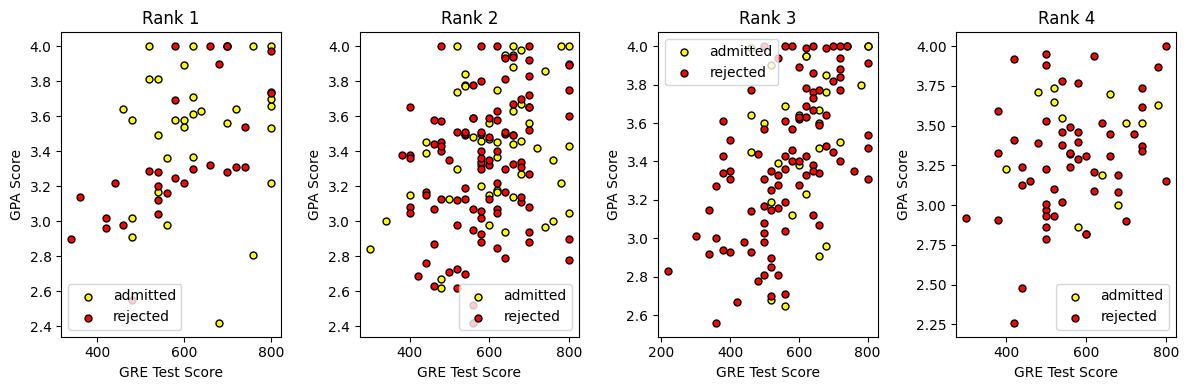

In [8]:
plt.figure(figsize = (12, 4))
plt.subplot(1, 4, 1)
plot_points(data_rank1)
plt.title("Rank 1")
plt.subplot(1, 4, 2)
plot_points(data_rank2)
plt.title("Rank 2")
plt.subplot(1, 4, 3)
plot_points(data_rank3)
plt.title("Rank 3")
plt.subplot(1, 4, 4)
plot_points(data_rank4)
plt.title("Rank 4")

plt.tight_layout()
plt.show()

The scatter plots show, there is a correlation between rank and admission. Lower the rank, higher the acceptance rate.

### Pre-processing the data for analyze

In [3]:
one_hot_data = pd.get_dummies(data['rank'], prefix='rank_', dtype=int)
one_hot_data = pd.concat([data, one_hot_data], axis = 1)
one_hot_data = one_hot_data.drop("rank", axis = 1)
one_hot_data.head(5)

,admit,gre,gpa,rank__1,rank__2,rank__3,rank__4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1


In [4]:
scale_data = one_hot_data[:]
scale_data['gre'] = scale_data['gre'] / np.max(scale_data['gre'])
scale_data['gpa'] = scale_data['gpa'] / np.max(scale_data['gpa'])
scale_data.head(5)

,admit,gre,gpa,rank__1,rank__2,rank__3,rank__4
0,0,0.475,0.9025,0,0,1,0
1,1,0.825,0.9175,0,0,1,0
2,1,1.000,1.0000,1,0,0,0
3,1,0.800,0.7975,0,0,0,1
4,0,0.650,0.7325,0,0,0,1


In [5]:
sample = np.random.choice(scale_data.index, size=int(len(scale_data)*0.9), replace=False)
train_data, test_data = scale_data.iloc[sample], scale_data.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))

print("Shape of training samples is", train_data.shape)
print("Shape of testing samples is", test_data.shape)

Number of training samples is 360
Number of testing samples is 40
Shape of training samples is (360, 7)
Shape of testing samples is (40, 7)


In [6]:
features = train_data.drop('admit', axis=1)
targets = train_data['admit']
features_test = test_data.drop('admit', axis=1)
target_test = test_data['admit']

print("Shape of fratures_train is: ", features.shape)
print("Shape of target_train is: ", targets.shape)

Shape of fratures_train is:  (360, 6)
Shape of target_train is:  (360,)


### Training Neuural Network

In [7]:
# Activation (sigmoid) & Error functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))
def error_formula(y, output):
    return (- y * np.log(output) - (1 - y) * np.log(1 - output))
def error_term_formula(y, output):
    return (y - output) * output * (1 - output)

In [8]:
def train_nn(features, targets, epochs, learnrate):
    np.random.seed(42)
    n_records, n_features = features.shape
    weights = np.random.normal(scale=(1 / n_features**0.5), size=n_features)
    losses = []
    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for x, y in zip(features.values, targets):
            output = sigmoid(np.dot(x, weights))
            error = error_formula(y, output)
            error_term = error_term_formula(y, output)
            del_w += error_term * x
            
        weights += learnrate * del_w / n_records
        if e % (epochs // 10) == 0:
            out = sigmoid(np.dot(features, weights))
            loss = np.mean((out - targets) ** 2)
            losses.append(loss)
    final_loss = losses[-1] if losses else None
    return weights, losses, final_loss

In [9]:
# Single Neural Network hyperparameters
epochs = 1000
learnrate = [5, 1, 0.5, 0.1, 0.05]

loss_results = {}
final_losses = {}

for lr in learnrate:
    weights, losses, final_loss = train_nn(features, targets, epochs, lr)
    loss_results[lr] = losses
    final_losses[lr] = final_loss
    print("Learning rate: ", lr, ", Final loss: ", final_loss)

best_lr = min(final_losses, key=final_losses.get)
print("Best learning rate is:", best_lr, ", with loss: ", final_losses[best_lr])

Learning rate:  5 , Final loss:  0.19576342409242165
Learning rate:  1 , Final loss:  0.20219469300093457
Learning rate:  0.5 , Final loss:  0.2036550965561953
Learning rate:  0.1 , Final loss:  0.20720413773798402
Learning rate:  0.05 , Final loss:  0.21013691357894004
Best learning rate is: 5 , with loss:  0.19576342409242165


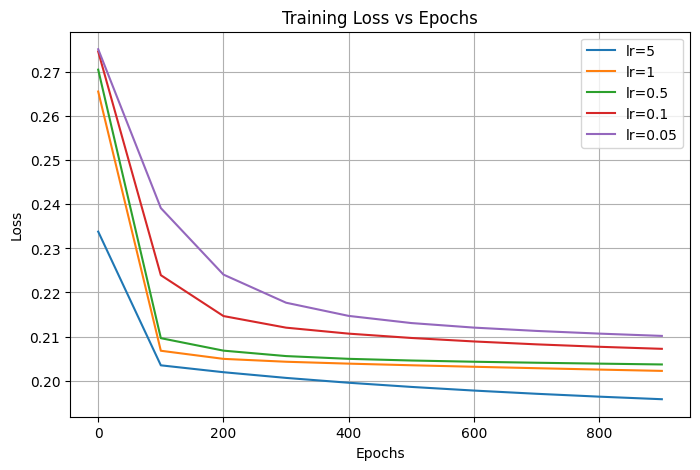

In [10]:
# Plot loss curves
plt.figure(figsize=(8, 5))
for lr, losses in loss_results.items():
    plt.plot(range(0, epochs, epochs / 10), losses, label=f"lr={lr}")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

we can see the best learning rate is 5, so now we will onece more train our model with learning rate 5 and check the accuracy of the model.

In [11]:
#train the model with best learning rate
best_weights,_,_ = train_nn(features, targets, epochs, best_lr)

### Calculate accuracy on test data

In [12]:
test_output = sigmoid(np.dot(features_test, best_weights))
predictions = test_output > 0.5
accuracy = np.mean(predictions == target_test)
print(f"Prediction accuracy: {accuracy:.3f}")

Prediction accuracy: 0.650


certainly, it can be seen that we have only 65% accuracy by this model, which is not good enough for prediction. However, lower data size, single layer perceptron might also the reason for this poor accuracy.